In [88]:
import pandas as pd
from pathlib import Path
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [89]:
RC = {
    "figure.figsize": (10, 5),
}
sns.set_theme(style="whitegrid", rc=RC)

In [90]:
ROOT_PATH = Path().resolve()
DATA_PATH = ROOT_PATH / 'DST_BIL54.csv'
assert DATA_PATH.exists()

OUTPUT_DIR = ROOT_PATH / 'output'
OUTPUT_DIR.mkdir(exist_ok=True)

# Assignment 1

In [91]:
# Read and format data
df = pd.read_csv(DATA_PATH)
df['time'] = pd.to_datetime(df['time'])  # Coerce to dt
df = df[["time", "total"]]
df = df.rename(columns={"total": "y"})

# Construct x columns as requested
df["x"] = df["time"].dt.year + (df["time"].dt.month - 1 ) / 12

TRAINING_CUTOFF = datetime.fromisoformat("2024-01-01")
df_train = df[df['time'] < TRAINING_CUTOFF].copy()
df_test = df[df['time'] >= TRAINING_CUTOFF].copy()

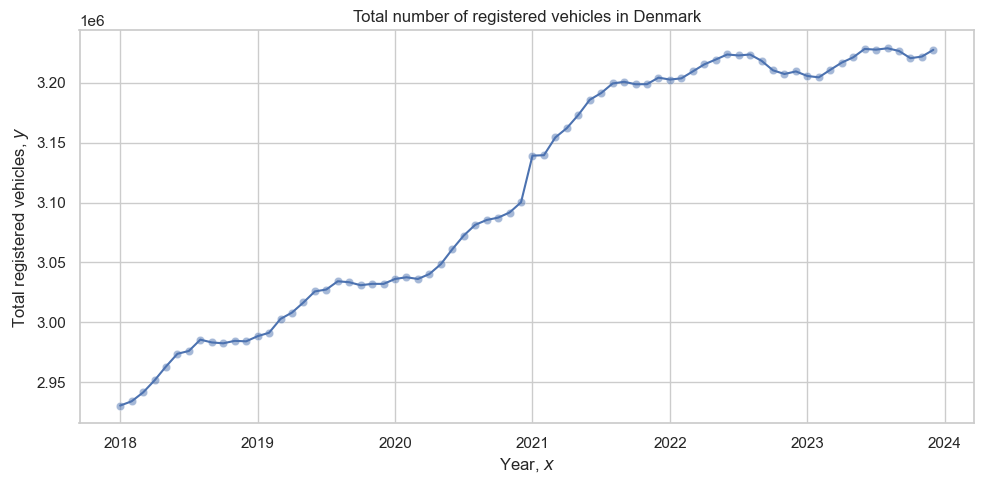

In [92]:
sns.lineplot(data=df_train, x="x", y="y")
sns.scatterplot(data=df_train, x="x", y="y", alpha=0.5)
plt.title("Total number of registered vehicles in Denmark")
plt.xlabel("Year, $x$")
plt.ylabel("Total registered vehicles, $y$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_observations.png", dpi=600)

# 1.2 Description of Data

We observe an increasing number of total registered vehicles in Denmark through the period from primo 2018 to ultimo 2023.
Notably, there is a sizable jump around the end of 2020, which flattens out in 2022. From 2022 onward we observe a smaller annual increase in the number of registered vehicles. This could be potentially be attributed to lower demand following the Coronavirus pandemic and the corresponding increase in remote working at many places of work. Alternatively, the reduction in the increase of registered cars could be seen as a consequence of increased fuel prices and uncertainty around the transition to Battery Electric Vehicles (BEV).



In [93]:
df_train[:3].round(3)

,time,y,x
0,2018-01-01,2930483,2018.000
1,2018-02-01,2934044,2018.083
2,2018-03-01,2941422,2018.167


## 2 - Linear Trend Model

We are given the following form of the General Linear Model (GLM):

$$
Y_t = θ_1 + θ_2 ⋅ x_t + ϵ_t
$$

### 2.1 - Matrix Form
We rewrite this in matrix-vector notation:

$$
\mathbf{\underbar{Y}} = \mathbf{\underbar{\underbar{X}}} \mathbf{\underbar{θ}} + \mathbf{\underbar{ϵ}}
$$

With $\mathbf{\underbar{\underbar{X}}}$ being the _design matrix_. In our case, for $N$ observations, this would be:

$$
\mathbf{\underbar{\underbar{X}}} ≡
\begin{bmatrix}
    1 & x_1 \\
    1 & x_2 \\
    ⋮ & ⋮ \\
    1 & x_n \\
\end{bmatrix}
$$

Using the first 3 time points in our training data set, we obtain:
$$
\begin{align}
\mathbf{\underbar{Y}}
&= \mathbf{\underbar{\underbar{X}}} \mathbf{\underbar{θ}} + \mathbf{\underbar{ϵ}}\\

\begin{bmatrix}
    y_1\\
    y_2\\
    y_3\\
\end{bmatrix}

&= \begin{bmatrix}
        1 & x_1 \\
        1 & x_2 \\
        1 & x_3 \\
    \end{bmatrix}

    \begin{bmatrix}
        θ_1\\
        θ_2\\
        θ_3\\
    \end{bmatrix}

    + 

    \begin{bmatrix}
        ϵ_1\\
        ϵ_2\\
        ϵ_3\\
    \end{bmatrix}\\

\begin{bmatrix}
    2930483\\
    2934044\\
    2941422\\
\end{bmatrix}

&= \begin{bmatrix}
        1 & 2018.000 \\
        1 & 2018.083 \\
        1 & 2018.167 \\
    \end{bmatrix}

    \begin{bmatrix}
        θ_1\\
        θ_2\\
        θ_3\\
    \end{bmatrix}

    + 

    \begin{bmatrix}
        ϵ_1\\
        ϵ_2\\
        ϵ_3\\
    \end{bmatrix}\\
\end{align}
$$



In [94]:
# We seek to solve for θ in the model



### 2.2 - Parameter Estimates

We wish to solve for $\mathbf{\underbar{θ}}$:

$$
\mathbf{\underbar{θ}} = (X^T X)^{-1} X^T Y
$$

And obtain estimates of the standard error

In [95]:

# df_train = df_train.iloc[:3]
X = np.zeros((len(df_train["x"]), 2))
X[:, 0] = 1
X[:, 1] = df_train["x"]

n, p = X.shape

Y = df_train["y"]

theta = np.linalg.inv(X.T @ X) @ X.T @ Y
theta

Y_hat = X @ theta
epsilon = Y - Y_hat

RSS = epsilon.T @ epsilon
sigma2 = RSS / (n - p)
covariance = sigma2 * np.linalg.inv(X.T @ X)
variances = np.diag(covariance)
standard_errors = np.sqrt(variances)

print(theta)
print(standard_errors)

theta_pred = theta


[-1.10355428e+08  5.61445562e+04]
[3.59358112e+06 1.77815630e+03]


In [113]:
# Prediction
df_prediction = df_train.copy()
X_prediction = np.empty((len(df_prediction["x"]), 2))
X_prediction[:, 0] = 1
X_prediction[:, 1] = df_prediction["x"]
df_prediction["y"] = X_prediction @ theta_pred

# TODO: Derive this in report
covariance_pred = sigma2 * (1 + X_prediction @ np.linalg.inv(X.T @ X) @ X_prediction.T)
variance_pred = np.diag(covariance_pred)
standard_errors_pred = np.sqrt(variance_pred)
p95_pred = 1.96 * standard_errors_pred
df_prediction["y_low"] = df_prediction["y"] - p95_pred
df_prediction["y_high"] = df_prediction["y"] + p95_pred


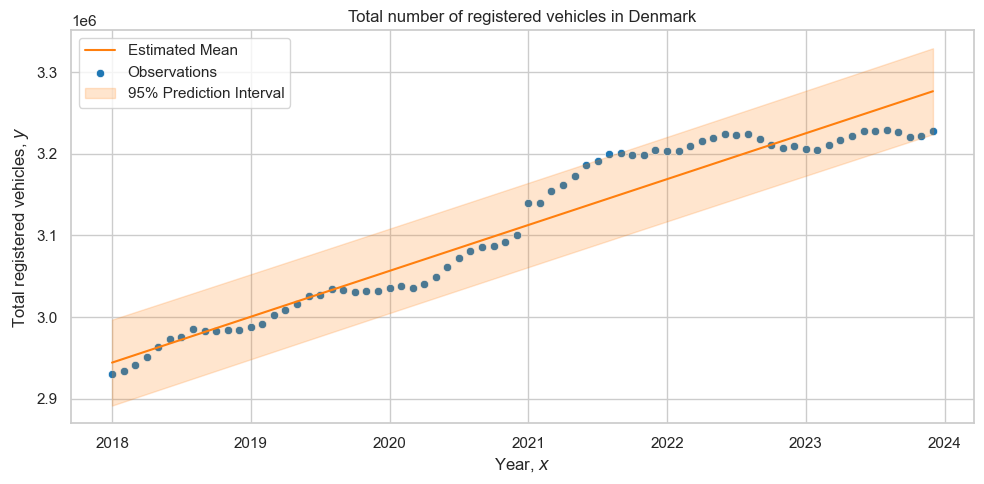

In [116]:
sns.lineplot(data=df_prediction, x="x", y="y", label="Estimated Mean", c="tab:orange")
sns.scatterplot(data=df_train, x="x", y="y", label="Observations", c="tab:blue")
plt.fill_between(df_prediction["x"], df_prediction["y_low"], df_prediction["y_high"], color="tab:orange", alpha=0.2, label="95% Prediction Interval")
plt.legend()
plt.title("Total number of registered vehicles in Denmark")
plt.xlabel("Year, $x$")
plt.ylabel("Total registered vehicles, $y$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_observations_predicted.png", dpi=600)

In [98]:
df_train

,time,y,x
0,2018-01-01,2930483,2018.000000
1,2018-02-01,2934044,2018.083333
2,2018-03-01,2941422,2018.166667
3,2018-04-01,2951498,2018.250000
4,2018-05-01,2963093,2018.333333
...,...,...,...
67,2023-08-01,3228835,2023.583333
68,2023-09-01,3226588,2023.666667
69,2023-10-01,3220559,2023.750000
70,2023-11-01,3221920,2023.833333


### 2.3 Prediction


In [120]:
rows_forecast = []
for i in range(12):
    rows_forecast.append({
        "time": datetime.fromisoformat(f"2024-{i + 1:02d}-01"),
        "x": 2024 + i / 12,
        "y": None
    })
df_forecast = pd.DataFrame(rows_forecast)
X_forecast = np.empty((len(df_forecast["x"]), 2))
X_forecast[:, 0] = 1
X_forecast[:, 1] = df_forecast["x"]
theta_pred = theta
df_forecast["y"] = X_forecast @ theta_pred

# Confidence intervals
covariance_forecast = sigma2 * (1 + X_forecast @ np.linalg.inv(X.T @ X) @ X_forecast.T)
variance_forecast = np.diag(covariance_forecast)
standard_errors_forecast = np.sqrt(variance_forecast)
p95_forecast = 1.96 * standard_errors_forecast
df_forecast["y_low"] = df_forecast["y"] - p95_forecast
df_forecast["y_high"] = df_forecast["y"] + p95_forecast

In [ ]:
df_forecast_output = df_forecast[["x", "y", "y_low", "y_high"]].copy()
df_forecast_output["x"] = df_forecast_output["x"].map("{:.3f}".format)
df_forecast_output[["y", "y_low", "y_high"]] = df_forecast_output[["y", "y_low", "y_high"]].astype(int)
df_forecast_output = df_forecast_output.rename(columns={
    "x": "Time",
    "y": "Total Vehicles Registered",
    "y_low": "95% Confidence Interval, lower bound",
    "y_high": "95% Confidence Interval, upper bound",
})
df_forecast_output.to_csv(OUTPUT_DIR / "forecast.csv", index=False)

### 2.4 Plot of forecast

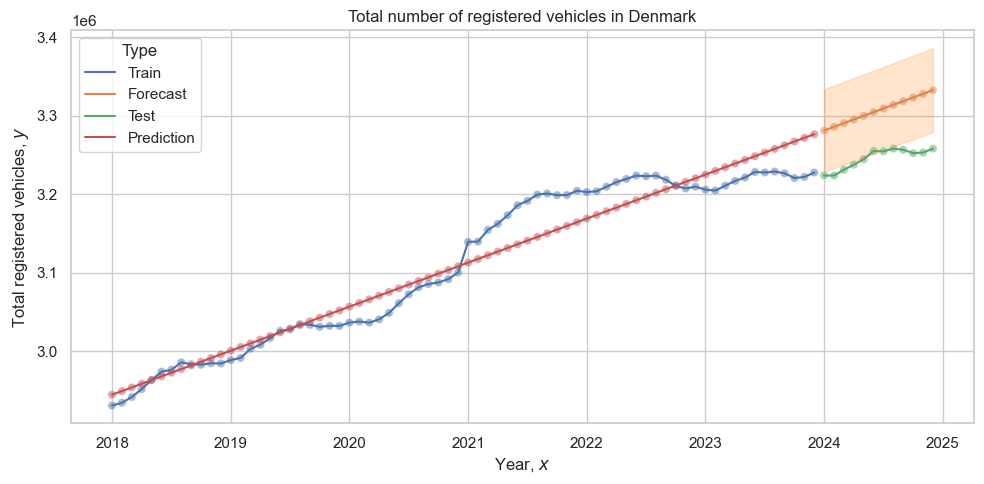

In [136]:
df_forecast["Type"] = "Forecast"
df_prediction["Type"] = "Prediction"
df_train["Type"] = "Train"
df_test["Type"] = "Test"
df_total = pd.concat([df_train, df_forecast, df_test, df_prediction])
# df_prediction
sns.lineplot(data=df_total, x="x", y="y", hue="Type")
sns.scatterplot(data=df_total, x="x", y="y", hue="Type", alpha=0.5, legend=False)
plt.fill_between(df_forecast["x"], df_forecast["y_low"], df_forecast["y_high"], color="tab:orange", alpha=0.2, label="95% Prediction Interval")
plt.title("Total number of registered vehicles in Denmark")
plt.xlabel("Year, $x$")
plt.ylabel("Total registered vehicles, $y$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_observations_forecast.png", dpi=600)

### 2.6 Residuals

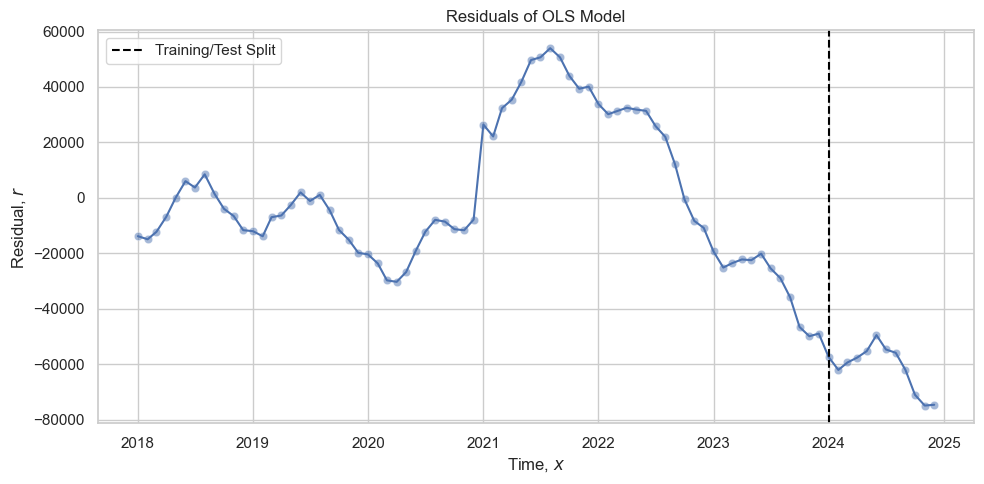

In [ ]:
df_total_residual = df_total.copy()

df_residuals = df_total.pivot(index="time", columns="Type", values="y")
# df_residuals = df_residuals[["Forecast", "Test"]]
# df_residuals = df_residuals.dropna(axis="index")
df_residuals["residual"] = df_residuals["Test"] - df_residuals["Forecast"]
df_residuals["residual"] = df_residuals["residual"].fillna(df_residuals["Train"] - df_residuals["Prediction"])
sns.lineplot(data=df_residuals, x="time", y="residual")
sns.scatterplot(data=df_residuals, x="time", y="residual", alpha=0.5)
plt.title("Residuals of OLS Model")
plt.xlabel("Time, $x$")
plt.ylabel("Residual, $r$")
plt.axvline(TRAINING_CUTOFF, color="black", linestyle="--", label="Training/Test Split")
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_2_6_forecast_residuals.png", dpi=600)

In [155]:
df_residuals

Type,Forecast,Prediction,Test,Train,residual
time,,,,,
2018-01-01,NaN,2.944286e+06,NaN,2930483.0,-13803.369129
2018-02-01,NaN,2.948965e+06,NaN,2934044.0,-14921.082148
2018-03-01,NaN,2.953644e+06,NaN,2941422.0,-12221.795167
2018-04-01,NaN,2.958323e+06,NaN,2951498.0,-6824.508185
2018-05-01,NaN,2.963001e+06,NaN,2963093.0,91.778796
...,...,...,...,...,...
2024-08-01,3.313905e+06,NaN,3258060.0,NaN,-55844.697620
2024-09-01,3.318583e+06,NaN,3256515.0,NaN,-62068.410639
2024-10-01,3.323262e+06,NaN,3252275.0,NaN,-70987.123658
